# 기어 설계 참고 사항

* Ref : http://blog.daum.net/gear-root/44

## 기어 정밀도 등급별 비교표 (대략)

_USA, FR, RU, UK 등은 생략_

|Nation |Standard                |  |  |  |  |  |  |  |  |  |  |  |  |  |
|-------|------------------------|--|--|--|--|--|--|--|--|--|--|--|--|--|
|ISO    |ISO 1328:1975           |0 |1 |2 |3 |4 |5 |6 |7 |8 |9 |10|11|12|
|KR     |KS B ISO 1328-1.2:2005  |0 |1 |2 |3 |4 |5 |6 |7 |8 |9 |10|11|12|
|JP     |JIS B 1702-1.2:1998     |0 |1 |2 |3 |4 |5 |6 |7 |8 |9 |10|11|12|
|DE    |DIN 3962.3:1959          |  |1 |2 |3 |4 |5 |6 |7 |8 |9 |10|11|12|
|KR(old) |KS B 1405-85:1971      |  |  |  |  |0 |1 |2 |3 |4 |5 |6 |7 |8 |
|JP(old) |KS B 1702:1976         |  |  |  |  |0 |1 |2 |3 |4 |5 |6 |7 |8 |

## 가공방법에 따른 정밀도 등급 한계 (대략)

_기계 상태가 좋고, 뛰어난 숙련공이 작업하고, 품질검수를 제대로 할 경우에는, 아래의 도달 한계등급보다 1등급 더 높은 등급까지 기대 가능_

|가공방법                    |도달 한계 등급(KS B ISO 1328-1.2:2005) |
|---------------------------|-------------------------------------|
|CNC (초경 CBN날로 마무리)    |6                                    |
|연삭(Grind) 마무리          |4                                    |
|쉐이빙(Shave) 마무리        |7                                    |
|랙커터(Rack Cutter) 셰이퍼(Shaper) 가공      |8                    |
|디스크 커터(Disc Cutter) 셰이퍼(Shaper) 가공  |9                    |
|AA급 호브(Hob)             |8                                    |
|A급 호브(Hob)              |9                                    |
|B급 호브(Hob)              |10                                    |
|사출성형                   |10                                    |

## 용도별 정밀도 등급 기준

* Ref : http://blog.daum.net/_blog/BlogTypeView.do?blogid=05KgA&articleno=16050627&_bloghome_menu=recenttext

|등급(KS B ISO 1328-1.2:2005)  |용도                   |가공방법           |
|-----------------------------|-----------------------|------------------|
|2                            |기준 원기용 마스터 기어   |형상 연마           |
|3                            |검사 부서의 마스터 기어   |형상 연마 및 창성 연마 |
|4                            |공장의 마스터 기어        |형상 연마 및 창성 연마 |
|4                            |측정기기의 매커니즘       |형상 연마 및 창성 연마 |
|4                            |초고속 회전, 극한 하중    |형상 연마 및 창성 연마 |
|5                            |산업용 로봇 정밀급 감속기  |형상 연마 및 창성 연마 |
|5,6                          |공작기계                |형상 연마 및 창성 연마 |
|5,6                          |항공기용 터빈 기어       |형상 연마 및 창성 연마 |
|5,6                          |측정기기의 구동          |형상 연마 및 창성 연마 |
|6,7                          |자동차 변속기의 최고속 부위 |호브,셰이퍼,쉐이빙후 경화하고, 이후 연마 |
|8,9                          |자동차 변속기의 중저속 부위 |호브,셰이퍼,쉐이빙후 경화 (연마 생략)   |
|8,9                          |철도차량                 |호브,셰이퍼,쉐이빙후 경화 (연마 생략)   |
|8,9                          |공구                    |호브,셰이퍼,쉐이빙후 경화 (연마 생략)   |
|8,9                          |사무기기                 |호브,셰이퍼,쉐이빙후 경화 (연마 생략)   |
|9                            |산업용 로봇의 감속기 입력기어 |호브,셰이퍼,쉐이빙후 경화 (연마 생략)   |
|10                           |일반기계(일반 변속기, 호이스트 등)   |인발, 소결, 사출성형         |
|11,12                        |일반 농업용 장비          |                  |



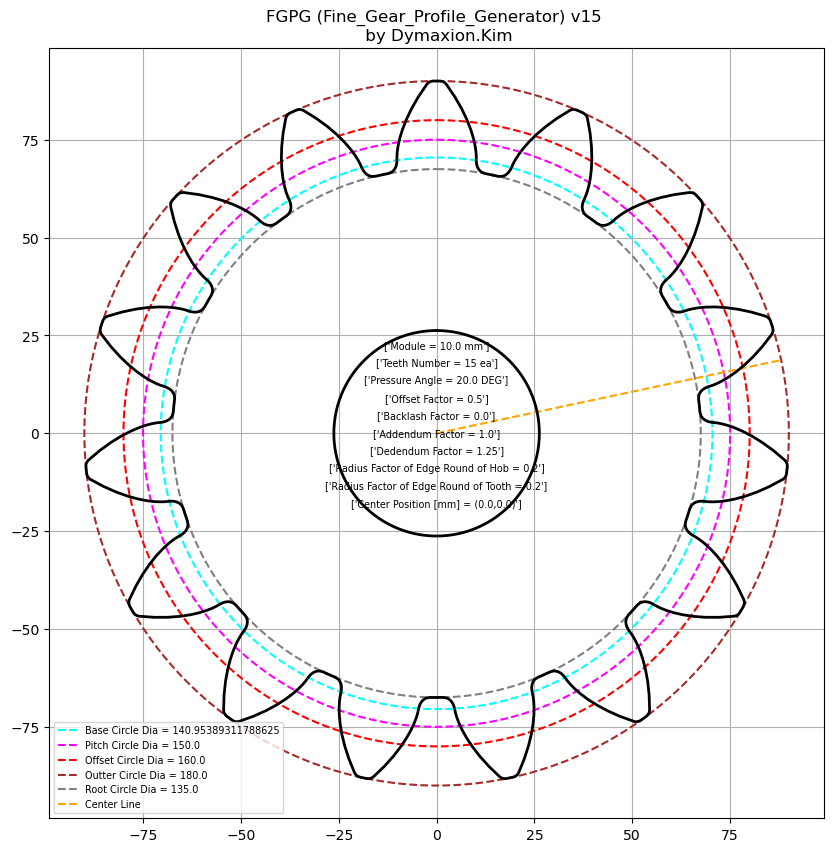

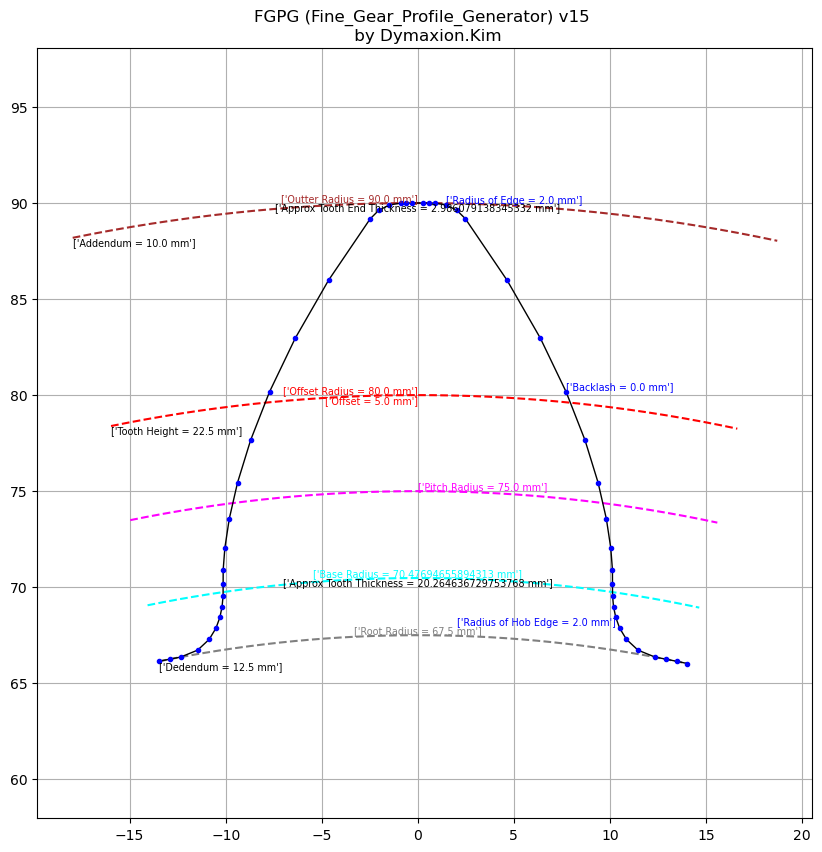

In [4]:
#########################################################################
# FGPG (Fine_Gear_Profile_Generator) V13
# 20200319
# by Dongho Kim  from Korea
# dymaxion.kim@gmail.com
# http://dymaxionkim.blogspot.kr/
#########################################################################
## Ref.
# http://tro.kr/29
# http://en.wikipedia.org/wiki/Coordinate_rotations_and_reflections
# http://dip28p.web.fc2.com/
#########################################################################
## History
# 20141114 V0.44 : SageMath Version
# 20150519 V0.1 : Trying to Conversion for Julia, Trying Interact Macro
# 20150519 V0.2 : Studying about Lack
# 20150527 V01 : Plotting Whole Gear at first
# 20150527 V02 : Trying Interact Macro
# 20150527 V03 : Debug V01
# 20150527 V04 : Adding Annotations, Saving Profile Data File, ...
# 20150527 V05 : Adding More Error Checks, Making geo File
# 20150528 V06 : Debug Making geo File
# 20150528 V07 : Align vertically Gear, Add Shaft
# 20150528 V08 : Modifying Sequences, Debug Making geo File, Make new Figure, Make svg Pictures, Save scr File, Modify Annotations
# 20150530 V09 : Modifying Shaft, Internal-External Condition, geo File
# 20150531 V10 : Adding version Variable
# 20150602 V11 : Making case.sif, case.bat, case.sh files
# 20161022 V12 : Conversion for Julia V0.5
# 20181127 V13 : Conversion for Julia V1.0
# 20200319 V14 : Add Some KS Standard Results
# 20200222 V15 : Add DataFrame argument for CSV.read() / xlrd do not support xlsx anymore.
#########################################################################
## Todo
# Write Theory Doc
# Write User Manual
# Write Some Actual Examples
# Tip Relief to Modifying Tooth Profile
# Profile Repairing in Undercut Condition
# Change Result File Name based in Time
# Build to Standalone Executable

using CSV
using DataFrames
using PyPlot
PyPlot.svg(true)

############################
# Parameters
version = "v15"
m = 1  # Module
z = 20  # Teeth Number
alpha_0_deg = 20  # Pressure Angle [Deg]
x = 0.2  # Offset Factor
b = 0  # Backlash Factor
a = 1.0  # Addendum of Tooth
d = 1.2  # Dedendum of Tooth
c = 0.3  # Radius Factor of Edge Round of Hob
e = 0.2  # Radius Factor of Edge Round of Tooth
# Center of Gear
x_0 = 0
y_0 = 0
# Segmentation Points Numbers for each curves
seg_circle = 360
seg_involute = 50
seg_edge_r = 4
seg_root_r = 20
seg_center = 2
seg_outter = 4
seg_root = 4


############################
# Input Parameters from input4fgpg.csv file
input4fgpg = CSV.read("input4fgpg.csv",DataFrame)
m = Float64(input4fgpg[1,3])
z = Int(input4fgpg[2,3])
alpha_0_deg = Float64(input4fgpg[3,3])
alpha_0 = alpha_0_deg*2*pi/360
x = Float64(input4fgpg[4,3])
b = Float64(input4fgpg[5,3])
a = Float64(input4fgpg[6,3])
d = Float64(input4fgpg[7,3])
c = Float64(input4fgpg[8,3])
e = Float64(input4fgpg[9,3])
x_0 = Float64(input4fgpg[10,3])
y_0 = Float64(input4fgpg[11,3])
seg_circle = Int(input4fgpg[12,3])
seg_involute = Int(input4fgpg[13,3])
seg_edge_r = Int(input4fgpg[14,3])
seg_root_r = Int(input4fgpg[15,3])
seg_center = Int(input4fgpg[16,3])
seg_outter = Int(input4fgpg[17,3])
seg_root = Int(input4fgpg[18,3])


############################
# Involute Curve
# alpha_m = Center Line's Slope [Rad]
alpha_m = pi/z
# alpha_is = Start Angle for Involute Curve
alpha_is = alpha_0 + pi/(2*z) + b/(z*cos.(alpha_0)) - (1+2*x/z)*sin.(alpha_0)/cos.(alpha_0)
# theta_is = Minimum Range of Parameter to Draw Involute Curve
theta_is = sin.(alpha_0)/cos.(alpha_0) + 2*(c*(1-sin.(alpha_0))+x-d)/(z*cos.(alpha_0)*sin.(alpha_0))
# theta_ie = Maximum Range of Parameter to Draw Involute Curve
theta_ie = 2*e/(z*cos.(alpha_0)) + sqrt.( ((z+2*(x+a-e))/(z*cos.(alpha_0)))^2 - 1 )
# Condition of theta_ie
if alpha_m<alpha_is+theta_ie-atan.(theta_ie)
    # theta_ie를 뉴튼라프슨법으로 수치해석하여 근사해를 다시 구해서 작도에 적용해야 함 (아직 미구현)
end
# Condition of Undercut
if theta_is<0 && (z/2)*sin.(alpha_0)^2<d-x-c*(1-sin.(alpha_0))
    # 언더컷 발생한 경우이므로, theta_ie, theta_te를 비선형 연립방정식 반복해법으로 다시 구해야 함 (아직 미구현)
end
THETA1 = range(theta_is,stop=theta_ie,length=seg_involute) 
X1 = ones(length(THETA1))
Y1 = X1
X1 = x_0 .+ (1 ./2).*m.*z.*cos.(alpha_0).*sqrt.(1 .+THETA1.^2).*cos.(alpha_is .+THETA1 .-atan.(THETA1))
Y1 = y_0 .+ (1 ./2).*m.*z.*cos.(alpha_0).*sqrt.(1 .+THETA1.^2).*sin.(alpha_is .+THETA1 .-atan.(THETA1))
#plot(X1,Y1,color="red",linestyle="-")


############################
# Edge Round Curve of Tooth
# alpha_e = Angle between Tooth's Center & End Point of Tooth
alpha_e = alpha_is + theta_ie - atan.(sqrt.( ( (z .+2*(x+a-e))/(z*cos.(alpha_0)) )^2 - 1 ))
# modify "e"
if alpha_e>alpha_m && alpha_m>alpha_is+theta_ie-atan.(theta_ie)
    e = (z/2)*cos.(alpha_0)*( theta_ie - sqrt.( (1/cos.(alpha_is+theta_ie-alpha_m))^2-1 ) )
end
# x_e, y_e = Location of Tooth's End Point
x_e = x_0 + m*((z/2)+x+a)*cos.(alpha_e)
y_e = y_0 + m*((z/2)+x+a)*sin.(alpha_e)
# x_e0, y_e0 = Location of Edge Round Center
x_e0 = m*(z/2+x+a-e)*cos.(alpha_e) + x_0
y_e0 = m*(z/2+x+a-e)*sin.(alpha_e) + y_0
# Parameter Range of Edge Round
theta3_min = atan.((Y1[length(Y1)]-y_e0)/(X1[length(X1)]-x_e0))
theta3_max = atan.((y_e-y_e0)/(x_e-x_e0))
THETA3 = range(theta3_min,stop=theta3_max,length=seg_edge_r) 
X3 = m*e*cos.(THETA3) .+ x_e0
Y3 = m*e*sin.(THETA3) .+ y_e0
#plot(X3,Y3,color="green",linestyle="-")


############################
# Root Round Curve of Tooth
# Condition Check
# alpha_ts = Start Angle of Root Round Curve
# THETA_s = Substitution Variable to plot Root Round Curve
alpha_ts = (2*(c*(1-sin.(alpha_0))-d)*sin.(alpha_0)+b)/(z*cos.(alpha_0)) - 2*c*cos.(alpha_0)/z + pi/(2*z)
theta_te = 2*c*cos.(alpha_0)/z - 2*(d-x-c*(1-sin.(alpha_0)))*cos.(alpha_0)/(z*sin.(alpha_0))
THETA_t  = range(0,stop=theta_te,length=seg_root_r) 
if c!=0 && (d-x-c)==0
    # mc를 반지름으로 하는 원호를 그려서 대체하게 됨
    THETA_s = (pi/2)*ones(length(THETA_t))
    elseif c==0 && (d-x-c)==0
    # 루트커브 작도 생략하고, (x_is,y_is) 점을 대칭으로 이뿌리호를 그려서 대체하게 됨
    elseif (d-x-c)!=0
    THETA_s = atan.((m*z*THETA_t/2)/(m*d-m*x-m*c))
end
X_t = x_0 .+ m*( (z/2+x-d+c).*cos.(THETA_t.+alpha_ts) .+ (z/2)*THETA_t.*sin.(THETA_t.+alpha_ts) - c.*cos.(THETA_s.+THETA_t.+alpha_ts) )
Y_t = y_0 .+ m*( (z/2+x-d+c).*sin.(THETA_t.+alpha_ts) .- (z/2)*THETA_t.*cos.(THETA_t.+alpha_ts) - c.*sin.(THETA_s.+THETA_t.+alpha_ts) )
#plot(X_t,Y_t,color="green",linestyle="-")


############################
# Outter Arc
#alpha_em = 2*alpha_m-alpha_e
#x_em = x_0 + m*(z/2+x+a)*cos.(alpha_em)
#y_em = y_0 + m*(z/2+x+a)*cos.(alpha_em)
THETA6  = range(alpha_e,stop=alpha_m,length=seg_outter) 
X6 = m*(z/2+a+x)*cos.(THETA6) .+x_0
Y6 = m*(z/2+a+x)*sin.(THETA6) .+y_0
#plot(X6,Y6,color="red",linestyle="-")


############################
# Root Arc
#x_rm = x_0 + m*(z/2+x-d)*cos.(alpha_ts)
#y_rm = y_0 - m*(z/2+x-d)*sin.(alpha_ts)
THETA7  = range(0,stop=alpha_ts,length=seg_root) 
X7 = m*(z/2-d+x)*cos.(THETA7) .+x_0
Y7 = m*(z/2-d+x)*sin.(THETA7) .+y_0
#plot(X7,Y7,color="red",linestyle="-")


############################
# Combine Curves
# Not using Root Round Curve (X_t,Y_t)
if c==0 && (d-x-c)==0
    Xc = X7[1:length(X7)-1]
    Yc = Y7[1:length(Y7)-1]
else
    Xc = [ X7[1:length(X7)-1]; X_t[1:length(X_t)-1] ]
    Yc = [ Y7[1:length(Y7)-1]; Y_t[1:length(Y_t)-1] ]
end
# Not using Edge Round Curve (X3,Y3)
if e==0 || alpha_m==alpha_is+theta_ie-atan.(theta_ie)
    Xc = [ Xc; X1[1:length(X1)-1] ]
    Yc = [ Yc; Y1[1:length(Y1)-1] ]
else
    Xc = [ Xc; X1[1:length(X1)-1]; X3[1:length(X3)-1] ]
    Yc = [ Yc; Y1[1:length(Y1)-1]; Y3[1:length(Y3)-1] ]
end
# Not using Outter Arc (X6,Y6)
if alpha_e == alpha_m || alpha_m==alpha_is+theta_ie-atan.(theta_ie)
    Xc = Xc
    Yc = Yc
else
    Xc = [ Xc; X6[1:length(X6)-1] ]
    Yc = [ Yc; Y6[1:length(Y6)-1] ]
end
#Xc = [ X7[1:length(X7)-1]; X_t[1:length(X_t)-1]; X1[1:length(X1)-1]; X3[1:length(X3)-1]; X6[1:length(X6)-1]]
#Yc = [ Y7[1:length(Y7)-1]; Y_t[1:length(Y_t)-1]; Y1[1:length(Y1)-1]; Y3[1:length(Y3)-1]; Y6[1:length(Y6)-1]]
#plot(Xc,Yc,color="black",linestyle="-",linewidth=2)


############################
# Make Whole One Tooth
Xc2 = Xc[2:length(Xc)]
Yc2 = Yc[2:length(Yc)]
# Reflect Transform
Xcc = cos.(2*alpha_m)*(Xc2 .-x_0) .+ sin.(2*alpha_m)*(Yc2 .-y_0)
Ycc = sin.(2*alpha_m)*(Xc2 .-x_0) .- cos.(2*alpha_m)*(Yc2 .-y_0)
# Location Transform to (x_0,y_0)
Xcc = Xcc .+ x_0
Ycc = Ycc .+ y_0
# Invert
Xcc = Xcc[length(Xcc):-1:1]
Ycc = Ycc[length(Ycc):-1:1]
# Combine
Xcc = [Xc; Xcc]
Ycc = [Yc; Ycc]
#plot(Xcc,Ycc,color="black",linestyle="-",linewidth=2)


############################
# Align to Top
align_angle = pi/2-pi/z
X_align = Xcc
Y_align = Ycc
# Rotate
X_align = cos.(align_angle)*(Xcc .-x_0) .- sin.(align_angle)*(Ycc .-y_0)
Y_align = sin.(align_angle)*(Xcc .-x_0) .+ cos.(align_angle)*(Ycc .-y_0)
# Location Transform to (x_0,y_0)
X_align = X_align .+ x_0
Y_align = Y_align .+ y_0
#plot(X_align,Y_align,color="black",linestyle="-",linewidth=2)


############################
# Make Whole Gear
p_angle = 2*pi/z
Xccc = X_align
Yccc = Y_align
Xtemp = X_align[2:length(X_align)]
Ytemp = Y_align[2:length(Y_align)]
for i = 1:z-1
    # Rotate
    Xtemp = cos.(p_angle*i).*(X_align[2:length(X_align)] .- x_0) .- sin.(p_angle*i).*(Y_align[2:length(Y_align)] .- y_0)
    Ytemp = sin.(p_angle*i).*(X_align[2:length(X_align)] .- x_0) .+ cos.(p_angle*i).*(Y_align[2:length(Y_align)] .- y_0)
    # Location Transform to (x_0,y_0)
    Xtemp = Xtemp .+ x_0
    Ytemp = Ytemp .+ y_0
    Xccc = [Xccc; Xtemp]
    Yccc = [Yccc; Ytemp]
end


############################
# Plot Figure
f=figure(figsize=(10,10))
grid("on")
title("FGPG (Fine_Gear_Profile_Generator) $version \n by Dymaxion.Kim")
axis("equal")


############################
# Base, Pitch, Offset, Outter, Root Circle
THETA0 = range(0.0,stop=2*pi,length=seg_circle) 
# Base Circle
base_dia = m*z*cos.(alpha_0)
X_base = base_dia/2*sin.(THETA0) .+ x_0
Y_base = base_dia/2*cos.(THETA0) .+ y_0
plot(X_base, Y_base, color="cyan", linestyle="--")
# Pitch Circle
pitch_dia = m*z
X_pitch = pitch_dia/2*sin.(THETA0) .+ x_0
Y_pitch = pitch_dia/2*cos.(THETA0) .+ y_0
plot(X_pitch, Y_pitch, color="magenta", linestyle="--")
# Offset Circle
offset_dia = 2*m*(z/2+x)
X_offset = (offset_dia/2)*sin.(THETA0) .+ x_0
Y_offset = (offset_dia/2)*cos.(THETA0) .+ y_0
plot(X_offset, Y_offset, color="red", linestyle="--")
# Outter Circle
outter_dia = 2*m*(z/2+x+a)
X_out = (outter_dia/2)*sin.(THETA0) .+ x_0
Y_out = (outter_dia/2)*cos.(THETA0) .+ y_0
plot(X_out, Y_out, color="brown", linestyle="--")
# Root Circle
root_dia = 2*m*(z/2+x-d)
X_root = (root_dia/2)*sin.(THETA0) .+ x_0
Y_root = (root_dia/2)*cos.(THETA0) .+ y_0
plot(X_root, Y_root, color="grey", linestyle="--")


############################
# Center Line of Tooth
X_m = range(x_0,stop=(m*(z/2+a+x))*cos.(alpha_m)+x_0,length=seg_center) 
Y_m = (X_m .- x_0).*tan.(alpha_m) .+ y_0
plot(X_m,Y_m,color="orange",linestyle="--")


############################
# Shaft
THETA8 = range(0,stop=2*pi,length=seg_circle) 
if a<d  # Outternal Gear
    d_shaft = m*(z+x-d)-m*(4*(a+d))
    elseif a>d  # Internal Gear
    d_shaft = m*(z+x+a)+m*(4*(a+d))
    elseif a==d  # No correct
    #d_shaft = m*(z+x-d)-m*(2*(a+d))
    d_shaft = 0
end
X_shaft = (d_shaft/2)*sin.(THETA8) .+ x_0
Y_shaft = (d_shaft/2)*cos.(THETA8) .+ y_0
plot(X_shaft, Y_shaft, color="black", linestyle="-", linewidth=2)


############################
# Plot Whole Gear
plot(Xccc,Yccc,color="black",linestyle="-",linewidth=2)
char_scale = 0.03*m*z
annotate(["Module = $m mm"],xy=(x_0,y_0+5*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Teeth Number = $z ea"],xy=(x_0,y_0+4*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Pressure Angle = $alpha_0_deg DEG"],xy=(x_0,y_0+3*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Offset Factor = $x"],xy=(x_0,y_0+2*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Backlash Factor = $b"],xy=(x_0,y_0+1*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Addendum Factor = $a"],xy=(x_0,y_0+0*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Dedendum Factor = $d"],xy=(x_0,y_0-1*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Radius Factor of Edge Round of Hob = $c"],xy=(x_0,y_0-2*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Radius Factor of Edge Round of Tooth = $e"],xy=(x_0,y_0-3*char_scale),ha="center",va="center",color="black",fontsize="x-small")
annotate(["Center Position [mm] = ($x_0,$y_0)"],xy=(x_0,y_0-4*char_scale),ha="center",va="center",color="black",fontsize="x-small")
legend(["Base Circle Dia = $base_dia", "Pitch Circle Dia = $pitch_dia", "Offset Circle Dia = $offset_dia",
    "Outter Circle Dia = $outter_dia", "Root Circle Dia = $root_dia", "Center Line"], loc="lower left", fontsize="x-small")
savefig("case01.svg")


############################
# Figuer 2
f2=figure(figsize=(10,10))
grid("on")
title("FGPG (Fine_Gear_Profile_Generator) $version \n by Dymaxion.Kim")
axis("equal")


############################
# Base, Pitch, Offset, Outter, Root Circle 2
THETA9 = range(atan.(X_align[length(X_align)]/Y_align[length(Y_align)]),stop=atan.(X_align[1]/Y_align[1]),length=Int(seg_circle/10)) 
# Base Circle
X_base9 = base_dia/2*sin.(THETA9) .+ x_0
Y_base9 = base_dia/2*cos.(THETA9) .+ y_0
plot(X_base9, Y_base9, color="cyan", linestyle="--")
# Pitch Circle
X_pitch9 = pitch_dia/2*sin.(THETA9) .+ x_0
Y_pitch9 = pitch_dia/2*cos.(THETA9) .+ y_0
plot(X_pitch9, Y_pitch9, color="magenta", linestyle="--")
# Offset Circle
X_offset9 = (offset_dia/2)*sin.(THETA9) .+ x_0
Y_offset9 = (offset_dia/2)*cos.(THETA9) .+ y_0
plot(X_offset9, Y_offset9, color="red", linestyle="--")
# Outter Circle
X_out9 = (outter_dia/2)*sin.(THETA9) .+ x_0
Y_out9 = (outter_dia/2)*cos.(THETA9) .+ y_0
plot(X_out9, Y_out9, color="brown", linestyle="--")
# Root Circle
X_root9 = (root_dia/2)*sin.(THETA9) .+ x_0
Y_root9 = (root_dia/2)*cos.(THETA9) .+ y_0
plot(X_root9, Y_root9, color="grey", linestyle="--")


############################
# Plot only One Tooth
plot(X_align,Y_align,color="black",linestyle="-",linewidth=1)
plot(X_align,Y_align,"b.")
base_radius = base_dia/2
pitch_radius = pitch_dia/2
offset_radius = offset_dia/2
outter_radius = outter_dia/2
root_radius = root_dia/2
xmm = x*m
emm = e*m
bmm = b*m
cmm = c*m
annotate(["Base Radius = $base_radius mm"],xy=(0,base_dia/2),ha="center",va="bottom",color="cyan",fontsize="x-small")
annotate(["Pitch Radius = $pitch_radius mm"],xy=(0,pitch_dia/2),ha="left",va="bottom",color="magenta",fontsize="x-small")
annotate(["Offset Radius = $offset_radius mm"],xy=(0,offset_dia/2),ha="right",va="bottom",color="red",fontsize="x-small")
annotate(["Outter Radius = $outter_radius mm"],xy=(0,outter_dia/2),ha="right",va="bottom",color="brown",fontsize="x-small")
annotate(["Root Radius = $root_radius mm"],xy=(0,root_dia/2),ha="center",va="bottom",color="grey",fontsize="x-small")
annotate(["Offset = $xmm mm"],xy=(0,offset_dia/2),ha="right",va="top",color="red",fontsize="x-small")
annotate(["Radius of Hob Edge = $cmm mm"],
        xy=(X_align[seg_root+Int(seg_root_r/2)],Y_align[seg_root+Int(seg_root_r/2)]),
        ha="right",va="top",color="blue",fontsize="x-small")
annotate(["Radius of Edge = $emm mm"],
        xy=(X_align[seg_root+seg_root_r+seg_involute],Y_align[seg_root+seg_root_r+seg_involute]),
        ha="left",va="bottom",color="blue",fontsize="x-small")
annotate(["Backlash = $bmm mm"],
        xy=(X_align[seg_root+seg_root_r+Int(seg_involute/2)],Y_align[seg_root+seg_root_r+Int(seg_involute/2)]),
        ha="left",va="bottom",color="blue",fontsize="x-small")
amm = a*m
dmm = d*m
hmm = amm+dmm
tmm = 2*X_align[seg_root+seg_root_r]
#temm = 2*X_align[seg_root+seg_root_r+seg_involute+Int(seg_edge_r/2)]
temm = 2*X_align[seg_root+seg_root_r+seg_involute]
annotate(["Addendum = $amm mm"],xy=(X_out9[1],Y_out9[1]),ha="left",va="top",color="black",fontsize="x-small")
annotate(["Dedendum = $dmm mm"],xy=(X_root9[1],Y_root9[1]),ha="left",va="top",color="black",fontsize="x-small")
annotate(["Tooth Height = $hmm mm"],xy=(X_offset9[1],Y_offset9[1]),ha="left",va="top",color="black",fontsize="x-small")
annotate(["Approx Tooth Thickness = $tmm mm"],xy=(0,base_dia/2),ha="center",va="top",color="black",fontsize="x-small")
annotate(["Approx Tooth End Thickness = $temm mm"],xy=(0,outter_dia/2),ha="center",va="top",color="black",fontsize="x-small")

savefig("case02.svg")


############################
# Save case.geo
fileout = open("case.geo", "w")
println(fileout, "cl__1 = 1;")
num_Point_gear = length(Xccc)
num_Line_gear = num_Point_gear-1
num_Point_shaft = num_Point_gear + length(X_shaft) -1
num_Line_shaft = num_Point_shaft-1
for i=1:num_Point_gear
    println(fileout, "Point(",i,") = {",Xccc[i],", ",Yccc[i],", ",0,", ","cl__1};")
end
for i=num_Point_gear+1:num_Point_shaft
    println(fileout, "Point(",i,") = {",X_shaft[i-num_Point_gear],", ",Y_shaft[i-num_Point_gear],", ",0,", ","cl__1};")
end
for j=1:num_Line_gear
    println(fileout, "Line(",j,") = {",j,", ",j+1,"};")
end
println(fileout, "Line(",num_Line_gear+1,") = {",num_Line_gear+1,", ",1,"};")
for j=num_Line_gear+2:num_Line_shaft
    println(fileout, "Line(",j,") = {",j,", ",j+1,"};")
end
println(fileout, "Line(",num_Line_shaft+1,") = {",num_Line_shaft+1,", ",num_Line_gear+2,"};")
# Combine
#array_LineLoop = [1:num_Line_shaft+1]
array_LineLoop = Array{Int}(range(1,stop=num_Line_shaft+1,length=num_Line_shaft+1))
array_LineLoop[num_Line_gear+2:num_Line_shaft+1] = -array_LineLoop[num_Line_gear+2:num_Line_shaft+1]
array_LineLoop = string(array_LineLoop)
array_LineLoop = array_LineLoop[2:length(array_LineLoop)-1]
println(fileout, "Line Loop(",num_Line_shaft+3,") = {",array_LineLoop,"};")
println(fileout, "Plane Surface(",num_Line_shaft+3,") = {",num_Line_shaft+3,"};")
#Physical Line(13) = {8, 9};
#Physical Surface(14) = {11};
array_PhysicalLine = [num_Line_gear+2:num_Line_shaft+1]
array_PhysicalLine = string(array_PhysicalLine)
array_PhysicalLine = array_PhysicalLine[2:length(array_PhysicalLine)-1]
#println(fileout, "Physical Line(",num_Line_shaft+4,") = {",array_PhysicalLine,"};")
# Position for Normal Force
#position_NormalForce = (length(Xcc)-1) - (seg_root+seg_root_r-2) - (seg_involute-3)
#println(fileout, "Physical Line(",num_Line_shaft+5,") = {",position_NormalForce,"};")
# Fixed
#println(fileout, "Physical Surface(",num_Line_shaft+6,") = {",num_Line_shaft+3,"};")
println(fileout, "Mesh.ElementOrder = 2;")
println(fileout, "Mesh.RecombineAll = 1;")
close(fileout)


############################
# Save case01.scr (Total)
fileout = open("case01.scr", "w")
println(fileout, "spline")
for i=1:num_Point_gear
    println(fileout, Xccc[i],",",Yccc[i],",0")
end
println(fileout, Xccc[1],",",Yccc[1],",0")
println(fileout, "  ")
println(fileout, "circle")
println(fileout, x_0,",",y_0)
println(fileout, d_shaft/2)
close(fileout)

############################
# Save case02.scr (Single tooth)
fileout = open("case02.scr", "w")
println(fileout, "spline")
for i=1:length(X_align)
    println(fileout, X_align[i],",",Y_align[i],",0")
end
println(fileout, -X_align[1],",",Y_align[1])
println(fileout, "  ")
println(fileout, "circle")
println(fileout, x_0,",",y_0)
println(fileout, (outter_dia/2)+m)
println(fileout, "line")
println(fileout, x_0,",",y_0)
println(fileout, x_0,",",(outter_dia/2)+m)
println(fileout, "")
println(fileout, "array")
println(fileout, "L")
println(fileout, "")
println(fileout, "P")
println(fileout, x_0,",",y_0)
println(fileout, Int(z*2))
println(fileout, "360")
println(fileout, "Y")
close(fileout)


# 기어 등급에 따른 오차 허용값 산출

_KS B ISO 1328-1:2005, 원통 기어 - 정밀도 등급 제1부 : 기어의 이에 관한 오차의 정의 및 허용값_


In [5]:
## 원하는 정밀도 등급 (0~12급, 계산공식은 5급 기준이고, 이웃 등급과는 sqrt(2) 곱하기 만큼씩 차이가 남)
KS = 5;
KS = Int(input4fgpg[21,3]);

## 구표준 KS B 1405-85 : 1971 정밀도 등급
KS_old = KS-4;
if KS_old<0; KS_old=0; end

## 기준원 지름 (d) 기하평균
KS_d = 0.0;
if pitch_dia <= 5.0;     KS_d = sqrt(0.0+5.0);
    elseif pitch_dia <= 20.0;    KS_d = sqrt(5.0+20.0);
    elseif pitch_dia <= 50.0;    KS_d = sqrt(20.0+50.0);
    elseif pitch_dia <= 125.0;    KS_d = sqrt(50.0+125.0);
    elseif pitch_dia <= 280.0;    KS_d = sqrt(125.0+280.0);
    elseif pitch_dia <= 560.0;    KS_d = sqrt(280.0+560);
    elseif pitch_dia <= 1000.0;    KS_d = sqrt(560.0+1000.0);
    elseif pitch_dia <= 1600.0;    KS_d = sqrt(1000.0+1600.0);
    elseif pitch_dia <= 2500.0;    KS_d = sqrt(1600.0+2500.0);
    elseif pitch_dia <= 4000.0;    KS_d = sqrt(2500.0+4000.0);
    elseif pitch_dia <= 6000.0;    KS_d = sqrt(4000.0+6000.0);
    elseif pitch_dia <= 8000.0;    KS_d = sqrt(6000.0+8000.0);
    elseif pitch_dia <= 10000.0;    KS_d = sqrt(8000.0+10000.0);
end

## 모듈(치직각 모듈;정면모듈) (m) 기하평균
KS_m = 0.0;
if m <= 0.5;    KS_m = sqrt(0.0+0.5);
    elseif m <= 2.0;    KS_m = sqrt(0.5+2.0);
    elseif m <= 3.5;    KS_m = sqrt(2.0+3.5);
    elseif m <= 6.0;    KS_m = sqrt(3.5+6.0);
    elseif m <= 10.0;    KS_m = sqrt(6.0+10.0);
    elseif m <= 16.0;    KS_m = sqrt(10.0+16.0);
    elseif m <= 25.0;    KS_m = sqrt(16.0+25.0);
    elseif m <= 40.0;    KS_m = sqrt(25.0+40.0);
    elseif m <= 70.0;    KS_m = sqrt(40.0+70.0);
end

## 치폭 (b) 기하평균 (헬리컬 기어일 경우)
temp_b = 10.0;
temp_b = Float64(input4fgpg[19,3]);
KS_b = 10.0;
if temp_b <= 4.0;    KS_m = sqrt(0.0+4.0);
    elseif temp_b <= 10.0;    KS_m = sqrt(4.0+10.0);
    elseif temp_b <= 20.0;    KS_m = sqrt(10.0+20.0);
    elseif temp_b <= 40.0;    KS_m = sqrt(20.0+40.0);
    elseif temp_b <= 80.0;    KS_m = sqrt(40.0+80.0);
    elseif temp_b <= 160.0;    KS_m = sqrt(80.0+160.0);
    elseif temp_b <= 250.0;    KS_m = sqrt(160.0+250.0);
    elseif temp_b <= 400.0;    KS_m = sqrt(250.0+400.0);
    elseif temp_b <= 650.0;    KS_m = sqrt(400.0+650.0);
    elseif temp_b <= 1000.0;    KS_m = sqrt(650.0+1000.0);
end

## 연속 피치수 (k)
## 일반적으로, 2보다 크고, 기어이빨개수(z)의 1/8 보다 작은 정수 값을 선택하여, 직접 입력해 줄 것.
KS_k = 0;
KS_k = Int(input4fgpg[20,3]);


############################
# 오차 계산

## 단일피치오차 (f_pt)
f_pt = 0.0;
f_pt = 0.3*(KS_m+0.4*sqrt(KS_d))+4.0;

## 부분 누적 피치 오차 (F_pk)
F_pk = 0.0;
F_pk = f_pt+1.6*sqrt((KS_k-1.0)*KS_m);

## 누적 피치 오차 (F_p)
F_p = 0.0;
F_p = 0.3*KS_m+1.25*sqrt(KS_d)+7.0;

## 전 치형 오차 (F_alpha)
F_alpha = 0.0;
F_alpha = 3.2*sqrt(KS_m)+0.22*sqrt(KS_d)+0.7;

## 전 잇줄 오차 (F_beta) - 헬리컬 기어에만 해당
F_beta = 0.0;
F_beta = 0.1*sqrt(KS_d)+0.63*sqrt(KS_b)+4.2;


############################
# 등급별로 오차값 산출
i = 0;
KS_factor = 0.0;
if KS==0;    i=(-5);
    elseif KS==1;    i=(-4);
    elseif KS==2;    i=(-3);
    elseif KS==3;    i=(-2);
    elseif KS==4;    i=(-1);
    elseif KS==5;    i=0;
    elseif KS==6;    i=1;
    elseif KS==7;    i=2;
    elseif KS==8;    i=3;
    elseif KS==9;    i=4;
    elseif KS==10;    i=5;
    elseif KS==11;    i=6;
    elseif KS==12;    i=7;
end
KS_factor = sqrt(2.0)^i;

 
f_pt = f_pt*KS_factor;
F_pk = F_pk*KS_factor;
F_p = F_p*KS_factor;
F_alpha = F_alpha*KS_factor;
F_beta = F_beta*KS_factor;

############################
# 수치의 맺음법
if f_pt > 5.0
    f_pt = floor(Int64, f_pt);
    else
    f_pt = floor(Int64,10*f_pt)/10;
end
if F_pk > 5.0
    F_pk = floor(Int64, F_pk);
    else
    F_pk = floor(Int64,10*F_pk)/10;
end
if F_p > 5.0
    F_p = floor(Int64, F_p);
    else
    F_p = floor(Int64,10*F_p)/10;
end
if F_alpha > 5.0
    F_alpha = floor(Int64, F_alpha);
    else
    F_alpha = floor(Int64,10*F_alpha)/10;
end
if F_beta > 5.0
    F_beta = floor(Int64, F_beta);
    else
    F_beta = floor(Int64,10*F_beta)/10;
end

############################
# 결과값 확인
println("정밀도 등급 : ",KS," (구표준 ",KS_old,", KS B 1405-85:1971)")
println("단일피치오차 (f_pt) : ±",f_pt,"um")
println("부분 누적 피치 오차 (F_pk) : ",F_pk,"um (연속피치수 k=",KS_k,")")
println("누적 피치 오차 (F_p) : ",F_p,"um")
println("전 치형 오차 (F_alpha) : ",F_alpha,"um")
#println("전 잇줄 오차 (F_beta) : ",F_beta,"um (헬리컬기어일 경우. 치폭 (b) : ",temp_b,"mm)")


정밀도 등급 : 9 (구표준 5, KS B 1405-85:1971)
단일피치오차 (f_pt) : ±22um
부분 누적 피치 오차 (F_pk) : 35um (연속피치수 k=2)
누적 피치 오차 (F_p) : 54um
전 치형 오차 (F_alpha) : 31um


# 기어 등급에 따른 백래시(Backlash) 산출

_KS B 1411:2016, 스퍼 기어 및 헬리컬 기어의 백래시_


In [6]:
# Read Backlash Data
using ExcelReaders
KS_Backlash = readxl("KSB1411_Backlash_Data.xls", join([string(KS_old),"!C2:M41"]))

# Focus on Module (m)
i = 0;
if m<=0.5; i=1;
    elseif m<=1.0; i=3;
    elseif m<=1.5; i=5;
    elseif m<=2.0; i=7;
    elseif m<=2.5; i=9;
    elseif m<=3.0; i=11;
    elseif m<=3.5; i=13;
    elseif m<=4.0; i=15;
    elseif m<=5.0; i=17;
    elseif m<=6.0; i=19;
    elseif m<=7.0; i=21;
    elseif m<=8.0; i=23;
    elseif m<=10.0; i=25;
    elseif m<=12.0; i=27;
    elseif m<=14.0; i=29;
    elseif m<=16.0; i=31;
    elseif m<=18.0; i=33;
    elseif m<=20.0; i=35;
    elseif m<=22.0; i=37;
    elseif m<=25.0; i=39;
end
KS_Backlash = KS_Backlash[i:(i+1),:,];

# Focus on Pitch Diameter (pitch_dia)
if pitch_dia<1.5; println("Too small pitch_dia");
    elseif pitch_dia<=3.0; i=1;
    elseif pitch_dia<=6.0; i=2;
    elseif pitch_dia<=12.0; i=3;
    elseif pitch_dia<=25.0; i=4;
    elseif pitch_dia<=50.0; i=5;
    elseif pitch_dia<=100.0; i=6;
    elseif pitch_dia<=200.0; i=7;
    elseif pitch_dia<=400.0; i=8;
    elseif pitch_dia<=800.0; i=9;
    elseif pitch_dia<=1600.0; i=10;
    elseif pitch_dia<=3200.0; i=11;
end
KS_Backlash = KS_Backlash[:,i];
KS_Backlash[1] = parse(Float64,KS_Backlash[1]);
KS_Backlash[2] = parse(Float64,KS_Backlash[2]);

println("Minimum Backlash : ",KS_Backlash[1],"um")
println("Average Backlash : ",(KS_Backlash[1]+KS_Backlash[2])/2.0,"um (Factor ",(((KS_Backlash[1]+KS_Backlash[2])/2.0)/1000.0)/m,")")
println("Maximum Backlash : ",KS_Backlash[2],"um")

Minimum Backlash : 120.0um
Average Backlash : 325.0um (Factor 0.0325)
Maximum Backlash : 530.0um


# 걸치기 이두께 치수 산출

_KS B 1406:1990, 스퍼기어 및 헬리컬기어의 측정 방법_

In [7]:
if z>=6 && z<=17;    KS_Zm=2;
    elseif z<=26;    KS_Zm=3;
    elseif z<=35;    KS_Zm=4;
    elseif z<=44;    KS_Zm=5;
    elseif z<=53;    KS_Zm=6;
    elseif z<=62;    KS_Zm=7;
    elseif z<=71;    KS_Zm=8;
    elseif z<=80;    KS_Zm=9;
    elseif z<=89;    KS_Zm=10;
    elseif z<=98;    KS_Zm=11;
    elseif z<=197;    KS_Zm=12;
    elseif z<=116;    KS_Zm=13;
    elseif z<=125;    KS_Zm=14;
    elseif z<=134;    KS_Zm=15;
    elseif z<=143;    KS_Zm=16;
    elseif z<=150;    KS_Zm=17;
    else println("기어의 잇수(z)가 규정범위를 벗어남.")
end

#KS_Zm = KS_k;
KS_omega = 0.0;
KS_omega = m*cos(alpha_0)*(pi*(KS_Zm-0.5)+z*(tan(alpha_0)-alpha_0))+2.0*x*m*sin(alpha_0);
KS_omega = floor(Int64,KS_omega*10000.0)/10000.0;

## Backlash
# Ref : http://m.blog.daum.net/again114/37
KS_omega_Backlash_Min = -(KS_Backlash[1]*cos(alpha_0))/1000.0;
KS_omega_Backlash_Min = floor(Int64,KS_omega_Backlash_Min*10000.0)/10000.0;
KS_omega_Backlash_Max = -(KS_Backlash[2]*cos(alpha_0))/1000.0;
KS_omega_Backlash_Max = floor(Int64,KS_omega_Backlash_Max*10000.0)/10000.0;

println("걸치기 잇수 (Zm) : ",KS_Zm,"ea")
println("걸치기 이두께 (omega) : ",KS_omega,"mm (",KS_omega_Backlash_Min,", ",KS_omega_Backlash_Max,")")

걸치기 잇수 (Zm) : 2ea
걸치기 이두께 (omega) : 49.803mm (-0.1128, -0.4981)


# 기어 요목표 출력

In [8]:
##############################################################################################
## Save case_spec.csv
fileout = open("case_spec.csv", "w")
if alpha_0_deg==20
    println(fileout, "치형, ","표준")
    else println(fileout, "치형, ","비표준")
end
println(fileout, "모듈, ",m,"mm")
println(fileout, "압력각, ",alpha_0_deg,"deg")
println(fileout, "잇수, ",z,"ea")
println(fileout, "기준 피치원 지름, ",pitch_dia,"mm")
println(fileout, "전위량(Factor), ",x)
println(fileout, "전체 이높이, ",a+d,"mm")
println(fileout, "걸치기 이두께"," (걸치기 잇수 ",KS_Zm,"), ",KS_omega,"mm (",KS_omega_Backlash_Min,"/",KS_omega_Backlash_Max,")")
println(fileout, "정밀도 (KS B ISO 1328-1:2005), ",KS,"급  / 구표준(KS B 1405-85:1971) : ",KS_old,"급")
println(fileout, "백래시(단일기어), ",KS_Backlash[1],"~",KS_Backlash[2],"um")
close(fileout)

println("Finish!")

Finish!
